# BioImagePy: experiment data processing

In this tutorial, we are going to batch process data in an `experiment`. **BioImagePy** comes with a module called `runner`. This module depends on the `experiment` module and the `process` module. Then it gives classes for both running queries data on an `experiment` and run process on selected data and register results to the experiment.

##### The experiment

In this tutorial, we will use the experiment created in the *tutorial1*. The experiment goal is explained in the *tutorial1*. As a reminder, we have two populations of images contained spots in noisy images. In this tutorial, we are going to segment and count the spots, and then run a statistical test to conclude if the two population have significantly different number of spots. 

## The Runner class

The **BioImagePy** runner module contains the main class `BiRunnerExperiment`. It's the only class we are going to use to process the data. Let's look the module documentation: 

In [1]:
import sys
sys.path.append("../bioimagepy") # change this path to the path where you install bioimagepy

import bioimagepy.runner as runnerpy
from bioimagepy.core import BiConfig

help(runnerpy)

Help on module bioimagepy.runner in bioimagepy:

NAME
    bioimagepy.runner - runner module.

DESCRIPTION
    This module contains the BiRunnerExperiment class that allows to run processes
    on an BiExperiment data (raw data and processed data). Results are automatically
    stored and indexed in a new BiProcessedDataSet in the BiExperiment
    
    Example
    -------
        Here is an example of how to run a process on all the data of the RawDataSet called 'data'
        and where the tag 'Population'='population1':
    
            >>> from bioimagepy.runner import BiRunnerExperiment
            >>> runner = BiRunnerExperiment(myexperiment)   
            >>> runner.set_process('/path/to/process/svdeconv2d.xml',
            >>>                '-sigma', '3', '-weighting', '0.1', '-regularization', '2') 
            >>> runner.add_input('-i', 'data', 'Population=population1 AND ID=002')
            >>> runner.run()
    
    Classes
    -------
    BiRunnerExperiment
    
    Raises

## Open the experiment

Thus, we need to create an instance of the experiment to process, and to give it to the `BiRunnerExperiment` class, and setup the class with the process inputs & outputs.

In [2]:
import bioimagepy.experiment as experimentpy

# open the experiment
myexperiment = experimentpy.BiExperiment('./myexperiment/experiment.md.json')
print("experiment opened")


experiment opened


## Processing

In the following of this tutorial, we are going to process the data in 3 steps.
1. Image deconvolution on each image to ease the spot segmentation
2. Auto thresholding and particle analysis on the deconvolutes images
3. Statistical testing with the wilcoxon test to conclude if the two population have significantly different number of spots

The 3 proposed steps are just one possible way to analyse the data, to illustrate the use of BioImagePy. Many other processing workflow are possible to analyse this dataset, but it is not the purpose of this tutorial.

### Step 1: image deconvolution

To make the spot segmentation easier to identify, we chose to preprocess the data with a deconvolution algorithm. The selected algorithm is the SVDeconv2D and it is available in **BioImagePy** using the `svdeconv2d.xml` wrapper. 

We thus instantiate a `BiRunnerExperiment`, we set the process to the `svdeconv2d.xml` process, add the input called *-i* to the dataset *data* with an empty query to select all the data in the *data* dataset

In [4]:
runner = runnerpy.BiRunnerExperiment(myexperiment) 
# set the toolshed configuration file to the runner
runner.set_config(BiConfig("../toolshed/config.json"))
# change this path to where you installed svdeconv2d
runner.set_process('../toolshed/svdeconv/wrappers/svdeconv2d.xml', '-sigma', '3', '-weighting', '0.1', '-regularization', '2', '-method', 'SV') 
runner.add_input('-i', 'data', '')
runner.run()

cmd: /Users/sprigent/Documents/code/tuto/toolshed/svdeconv/wrappers/../bin/svdeconv2d -i /Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/data/population1_001.tif -o /Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/SV_Deconv_2D/population1_001_-o.tif -sigma 3 -regularization 2 -weighting 0.1 -method SV -niter 200
cmd: /Users/sprigent/Documents/code/tuto/toolshed/svdeconv/wrappers/../bin/svdeconv2d -i /Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/data/population1_015.tif -o /Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/SV_Deconv_2D/population1_015_-o.tif -sigma 3 -regularization 2 -weighting 0.1 -method SV -niter 200
cmd: /Users/sprigent/Documents/code/tuto/toolshed/svdeconv/wrappers/../bin/svdeconv2d -i /Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/data/population1_014.tif -o /Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/SV_Deconv_2D/population1_014_-o.tif

cmd: /Users/sprigent/Documents/code/tuto/toolshed/svdeconv/wrappers/../bin/svdeconv2d -i /Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/data/population2_011.tif -o /Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/SV_Deconv_2D/population2_011_-o.tif -sigma 3 -regularization 2 -weighting 0.1 -method SV -niter 200
cmd: /Users/sprigent/Documents/code/tuto/toolshed/svdeconv/wrappers/../bin/svdeconv2d -i /Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/data/population2_005.tif -o /Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/SV_Deconv_2D/population2_005_-o.tif -sigma 3 -regularization 2 -weighting 0.1 -method SV -niter 200
cmd: /Users/sprigent/Documents/code/tuto/toolshed/svdeconv/wrappers/../bin/svdeconv2d -i /Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/data/population2_013.tif -o /Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/SV_Deconv_2D/population2_013_-o.tif

Let visualize the obtained results:

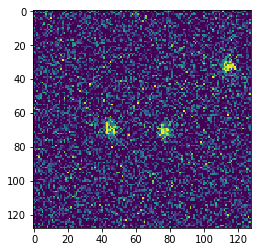

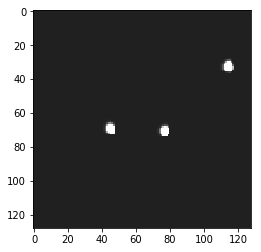

In [6]:
from bioimagepy.metadata import BiRawData, BiProcessedData
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# get the first processed data
processed_data = myexperiment.processeddataset(0).processed_data(0)

# get the origin data
origin_data = BiRawData(processed_data.origin_data())

# plot the origin data
img=mpimg.imread(origin_data.url())
imgplot = plt.imshow(img)
plt.show()

# plot the processed data
img=mpimg.imread(processed_data.url())
imgplot = plt.imshow(img)
plt.show()

### Step 2: Image segmentation

In this step, we apply an automatique threshold and a particle analysis in each images in order to obtain the number of spots in each images.

The selected algorithm is a Fiji macro that runs a auto-threshold and an analyse particles. It is available in **BioImagePy** using the `threshold_particles.xml` wrapper. 

We thus instantiate a `BiRunnerExperiment`, we set the process to the `threshold_particles.xml` process, add the input called *-input* to the dataset *SV_Deconv_2D* with an empty query to select all the data in the *data* dataset

In [7]:
runner = runnerpy.BiRunnerExperiment(myexperiment) 
runner.set_config(BiConfig("../toolshed/config.json"))
runner.set_process('../toolshed/fiji/wrapping/threshold_particles.xml', '-threshold', 'Default dark') 
runner.add_input('-input', 'SV_Deconv_2D', '')
runner.run()

cmd: /Applications/Fiji.app/Contents/MacOS/ImageJ-macosx --headless --console -macro /Users/sprigent/Documents/code/tuto/toolshed/fiji/wrapping/threshold_particles.ijm '[/Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/SV_Deconv_2D/population1_001_-o.tif,Default dark,/Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/Count_particles/population1_001_-o_-draw.tif,/Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/Count_particles/population1_001_-o_-count.csv,/Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/Count_particles/population1_001_-o_-measures.csv]'
cmd: /Applications/Fiji.app/Contents/MacOS/ImageJ-macosx --headless --console -macro /Users/sprigent/Documents/code/tuto/toolshed/fiji/wrapping/threshold_particles.ijm '[/Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/SV_Deconv_2D/population1_015_-o.tif,Default dark,/Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/Count_

cmd: /Applications/Fiji.app/Contents/MacOS/ImageJ-macosx --headless --console -macro /Users/sprigent/Documents/code/tuto/toolshed/fiji/wrapping/threshold_particles.ijm '[/Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/SV_Deconv_2D/population1_010_-o.tif,Default dark,/Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/Count_particles/population1_010_-o_-draw.tif,/Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/Count_particles/population1_010_-o_-count.csv,/Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/Count_particles/population1_010_-o_-measures.csv]'
cmd: /Applications/Fiji.app/Contents/MacOS/ImageJ-macosx --headless --console -macro /Users/sprigent/Documents/code/tuto/toolshed/fiji/wrapping/threshold_particles.ijm '[/Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/SV_Deconv_2D/population1_011_-o.tif,Default dark,/Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/Count_

cmd: /Applications/Fiji.app/Contents/MacOS/ImageJ-macosx --headless --console -macro /Users/sprigent/Documents/code/tuto/toolshed/fiji/wrapping/threshold_particles.ijm '[/Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/SV_Deconv_2D/population2_011_-o.tif,Default dark,/Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/Count_particles/population2_011_-o_-draw.tif,/Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/Count_particles/population2_011_-o_-count.csv,/Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/Count_particles/population2_011_-o_-measures.csv]'
cmd: /Applications/Fiji.app/Contents/MacOS/ImageJ-macosx --headless --console -macro /Users/sprigent/Documents/code/tuto/toolshed/fiji/wrapping/threshold_particles.ijm '[/Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/SV_Deconv_2D/population2_005_-o.tif,Default dark,/Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/Count_

cmd: /Applications/Fiji.app/Contents/MacOS/ImageJ-macosx --headless --console -macro /Users/sprigent/Documents/code/tuto/toolshed/fiji/wrapping/threshold_particles.ijm '[/Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/SV_Deconv_2D/population1_008_-o.tif,Default dark,/Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/Count_particles/population1_008_-o_-draw.tif,/Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/Count_particles/population1_008_-o_-count.csv,/Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/Count_particles/population1_008_-o_-measures.csv]'
cmd: /Applications/Fiji.app/Contents/MacOS/ImageJ-macosx --headless --console -macro /Users/sprigent/Documents/code/tuto/toolshed/fiji/wrapping/threshold_particles.ijm '[/Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/SV_Deconv_2D/population1_009_-o.tif,Default dark,/Users/sprigent/Documents/code/tuto/bioimagepy-tutorial/myexperiment/Count_

### Step 3: Statistical test

In the previous step, the segmentation algorithm calulated the number of spots for each images. Then, we now need to perform a statistical test to measure if the spot number is statistically different for the two populations.

We will use the Wilcoxon test available in **BioImagePy** using the `wilcoxon.xml` wrapper. 


In [ ]:
runner = runnerpy.BiRunnerExperiment(myexperiment)   
runner.set_config(BiConfig("../toolshed/config.json"))
runner.set_process('../toolshed/python/wrapping/wilcoxon.xml') 
runner.add_input('-x', 'Count_particles', 'Population=population1', '-count')
runner.add_input('-y', 'Count_particles', 'Population=population2', '-count')
runner.run() 

With the code above, the Wilcoxon test has been performed between *population1* and *population2* using the result `-count` of the process `Count_partices`. 

Because the `wilcoxon.xml` process works on merged data, we do not need to 'manualy' merge the coint results in array files since **BioImagePy** do it for us.

Now we can read the results of the Wicoxon test:

In [ ]:
wilcoxon_pvalue_file = myexperiment.processeddataset_by_name('Wilcoxon').processed_data_by_name('-p').url()

with open(wilcoxon_pvalue_file, 'r') as content_file:
    p = content_file.read()
    
print('p-value=', p)    